<a href="https://colab.research.google.com/github/u-masao/vital_statistics_jp/blob/main/notebooks/02_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install package

In [1]:
!pip install vital-statistics-jp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


## Read data

Read monthly prompt data of vital statistics from "Ministry of Health" in japan.

https://www.mhlw.go.jp/toukei/list/81-1a.html

In [2]:
from vital_statistics_jp import read_prompt

stat_df = read_prompt()

print(stat_df)

         category         ts  value
0     live births 2005-01-01  95817
1     live births 2005-02-01  83516
2     live births 2005-03-01  90745
3     live births 2005-04-01  88001
4     live births 2005-05-01  90143
...           ...        ...    ...
1237     divorces 2021-11-01  15064
1238     divorces 2021-12-01  16471
1239     divorces 2022-01-01  14386
1240     divorces 2022-02-01  14051
1241     divorces 2022-03-01  20288

[1242 rows x 3 columns]


In [3]:
print(stat_df.category.unique())

['live births' 'marriages' 'deaths' 'foetal deaths' 'natural change'
 'divorces']


## Plot data

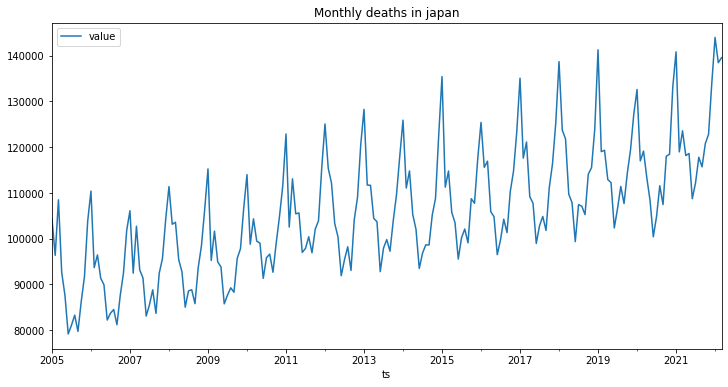

In [4]:
deaths_sr = stat_df.loc[stat_df.category=='deaths',['ts','value']].set_index('ts').astype(float)
deaths_sr.index.freq='MS'
deaths_sr.plot(title='Monthly deaths in japan', figsize=(12,6))

## Time series analysis

In [22]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

alpha=0.001

uc_model = sm.tsa.UnobservedComponents(
    np.log10(deaths_sr).loc[:"2022-01-01"],
    level='local linear trend',
    freq_seasonal=[{'period':12, 'harmonics':6}],
)

uc_model.initial_variance = np.log10(deaths_sr).std().pow(2)*10e6
print('initial variance:', uc_model.initial_variance)
uc_result = uc_model.fit()
predict = 10**uc_result.get_prediction(start='2010-01-01', end='2023-08-01', alpha=alpha).summary_frame()

initial variance: value    29740.331334
dtype: float64


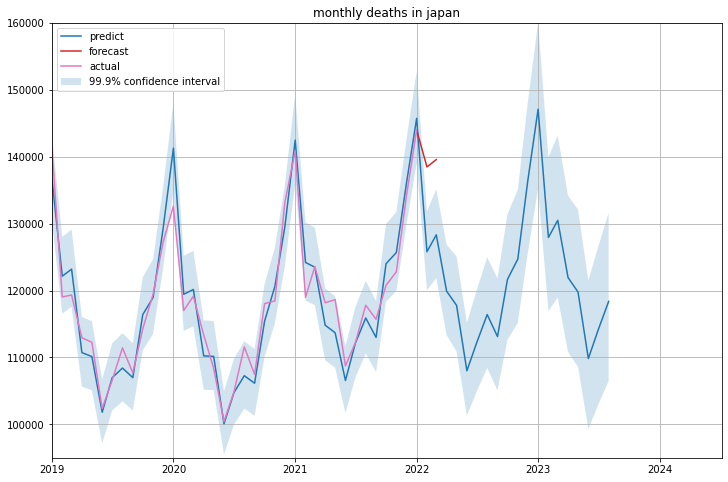

In [48]:
import datetime
cmap = plt.get_cmap("tab10")

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(
    predict.index, 
    predict['mean_ci_lower'], 
    predict['mean_ci_upper'], 
    alpha=0.2, 
    label=f'{(1-alpha)*100:0.1f}% confidence interval')
ax.plot(predict['mean'], label='predict')
ax.plot(deaths_sr.loc["2022-01-01":], label="forecast", color=cmap(3))
ax.plot(deaths_sr.loc[:"2022-01-01"], label="actual", color=cmap(6))

ax.legend(loc='upper left')
ax.grid()
ax.set_title('monthly deaths in japan')
ax.set_xlim(datetime.datetime(2019,1,1), None)
ax.set_ylim(95000,160000)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


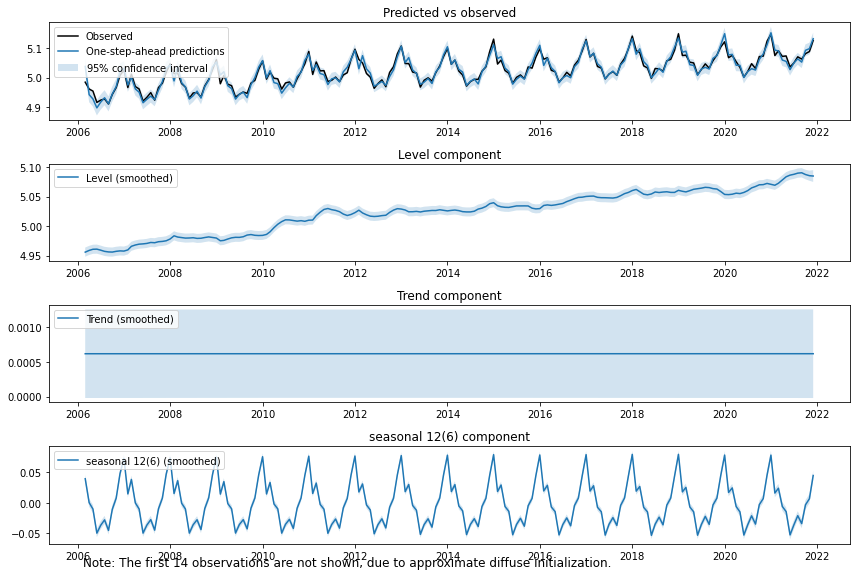

In [15]:
fig = plt.figure(figsize=(12,8))
uc_result.plot_components(fig=fig, legend_loc='upper left')
fig.tight_layout()
plt.show()

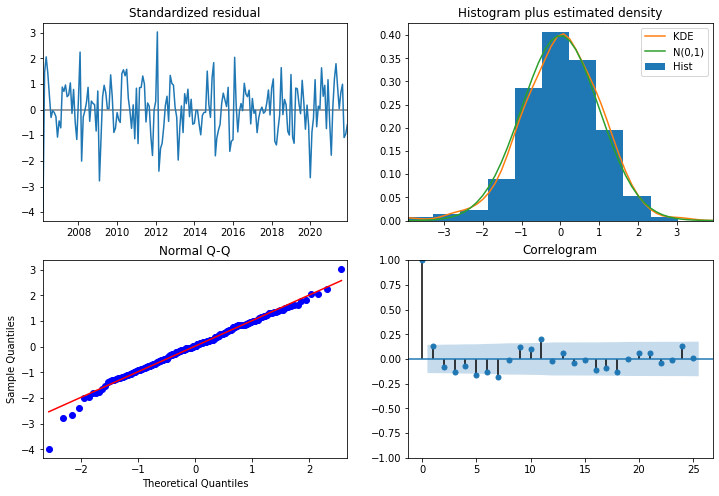

In [16]:
fig = plt.figure(figsize=(12,8))
uc_result.plot_diagnostics(fig=fig, lags=25)
plt.show()

In [17]:
uc_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                 value   No. Observations:                  204
Model:                            local linear trend   Log Likelihood                 592.134
                   + stochastic freq_seasonal(12(6))   AIC                          -1176.268
Date:                               Tue, 24 May 2022   BIC                          -1163.280
Time:                                       22:46:27   HQIC                         -1171.007
Sample:                                   01-01-2005                                         
                                        - 12-01-2021                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular            4.169e-05   6.87e-06      6.071      0.000    2.82e-05    5.51e-05
sigma2.level                2.108e-05   6.49e-06      3.249      0.001    8.36e-06    3.38e-05
sigma2.trend                1.785e-11   2.51e-08      0.001      0.999   -4.91e-08    4.92e-08
sigma2.freq_seasonal_12(6)  5.959e-08   3.62e-08      1.645      0.100   -1.14e-08    1.31e-07
===================================================================================
Ljung-Box (Q):                       62.52   Jarque-Bera (JB):                13.84
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.38
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""